In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task: plot up a couple of haloes for a comparison plot

Whether this makes it into the paper or not is another issue, but could be a nice issue to explain points in the paper.

I will use the 'typical' example of the Milky Way.

In [2]:
import halo_modified

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.3e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = None
delta_m_hi_mw = None

mw_halo = halo_modified.TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,
                                  a_b_mw,delta_a_b_mw,R_d_mw,delta_R_d_mw,
                                  m_hi_mw,delta_m_hi_mw,
                                  None,None,None,None,1,0)

m_h = mw_halo.halo_mass()[0].data * u.Msun
m_h_hernquist = mw_halo.halo_mass_hernquist()[0].data * u.Msun
rho0_burkert = mw_halo.burkert_rho0()[0].data * (u.Msun/u.kpc**3)
R_h = mw_halo.halo_scale_length()[0].data * u.kpc

In [3]:
def hernquist_halo(M,a,r):
    return (M/(2*math.pi)) * (a/r) * (1/(r+a)**3)

def burkert_halo(rho0,a,r):
    return rho0 * a**3 / ((r+a)*(r**2+a**2))

def nfw_halo(rho0,r_s,r):
    rho = rho0 /((r/r_s) * (1+r/r_s)**2)
    return rho
    

def alpha_halo(alpha):
    if alpha < 0:
        return (1+alpha)*rho_b
    elif 0 <= alpha <= 1:
        return alpha*rho_h + (1-alpha)*rho_b
    else:
        return (1+alpha)*rho_h

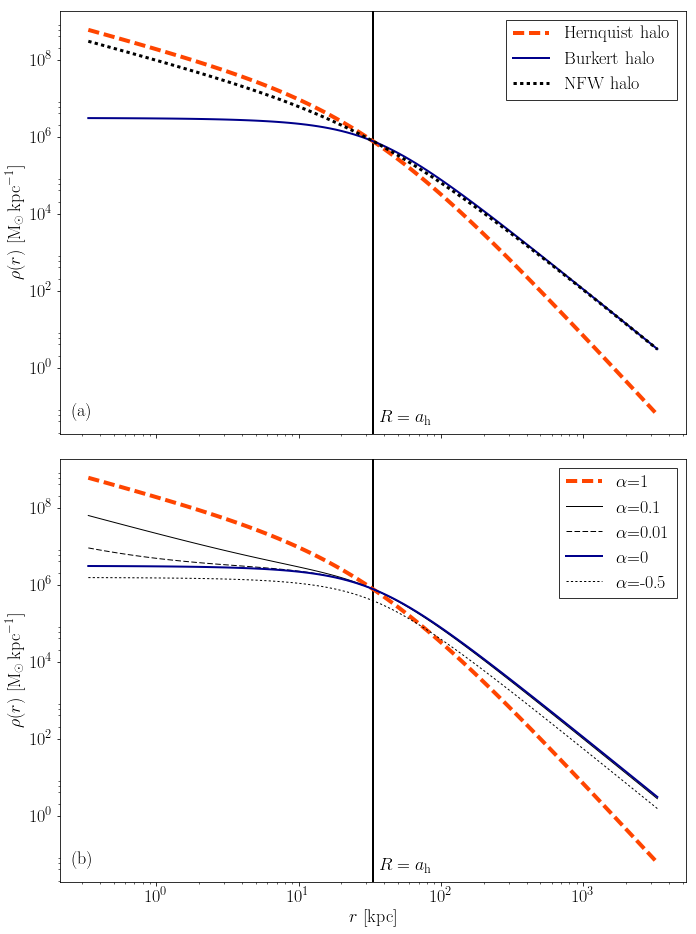

In [4]:
fig, axarr = plt.subplots(2,1,figsize=(10,13.3),sharex=True,sharey=True)

r = np.logspace(-2,2,100) * R_h.value
rho_h = hernquist_halo(m_h_hernquist.value,R_h.value,r)
rho_b = burkert_halo(rho0_burkert.value,R_h.value,r)
rho_n = nfw_halo(rho0_burkert.value,R_h.value,r)

ax = axarr[0]
plt.sca(ax)

_ = ax.plot(r,rho_h,color='orangered',lw=4,linestyle='dashed',
            label='Hernquist halo')
_ = ax.plot(r,rho_b,color='darkblue',lw=2,
            label='Burkert halo')
_ = ax.plot(r,rho_n,color='k',lw=3,linestyle='dotted',
            label='NFW halo')

##########################

ax = axarr[1]
plt.sca(ax)

alphas = (1,0.1,0.01,0,-0.5)
styles = ('dashed','solid','dashed','solid','dotted')
colors = ('orangered','k','k','darkblue','k')
linewidths = (4,1,1,2,1)

for a, style, color, lw in zip(alphas,styles,colors,linewidths):
    rho = alpha_halo(a)
    _ = ax.plot(r,rho,color=color,linestyle=style,lw=lw,
                label=r'$\alpha$={}'.format(a))

###########################
for ax in axarr:
    plt.sca(ax)
    _ = plt.axvline(R_h.value,lw=2,color='k',zorder=-1)
    _ = ax.set_xscale('log')
    _ = ax.set_yscale('log')
    _ = ax.legend(fancybox=False,edgecolor='k')
    _ = ax.set_ylabel(r'$\rho (r)$ [$\mathrm{M_\odot \, kpc^{-1}}$]')
    _ = ax.text(0.51,0.01,'$R=a_\mathrm{h}$',
            transform=ax.transAxes,ha='left',va='bottom')

_ = axarr[0].text(0.02,0.03,'(a)',transform=axarr[0].transAxes,
                  ha='left',va='bottom')   
_ = axarr[1].text(0.02,0.03,'(b)',transform=axarr[1].transAxes,
                  ha='left',va='bottom')  

_ = axarr[1].set_xlabel('$r$ [kpc]')
fig.tight_layout()
fig.savefig('figures/halo_shapes.pdf')

#### Now, for the science part -- we should be able to calculate the required flattening to produce our spiral arm numbers.

In [5]:
# load the required data
masks = Table.read('fits/masks.fits')
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
halo_data = Table.read('fits/sdss_halo_table_matched.fits')
halo_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

In [6]:
# what are the fd vs. m relations?
def m_to_fd(m,k,c):
    return (m - c)/k

def fd_to_alpha(fd,M_h,M_b,M_d,burkert=True):
    if burkert is True:
        return (1/M_h) * (M_d/fd-M_d-M_b) - 1
    else:
        return (1/M_h) * (M_d/fd-M_d-M_b)

def m_to_alpha(m,k,c,M_h,M_b,M_d,burkert=True):
    fd = m_to_fd(m,k,c)
    alpha = fd_to_alpha(fd,M_h,M_b,M_d,burkert)
    return alpha

k_h, c_h = 1.45, 1.14
k_b, c_b = 0.93, 0.97
k_h_hi, c_h_hi = 1.38, 1.07
k_b_hi, c_b_hi = 1.04, 0.78

def calculate_alpha(m_observed,m_burkert,m_hernquist,k_h,c_h,k_b,c_b,
                    M_b,M_d,M_h_hernquist,M_h_burkert):
    alphas = (m_observed - m_burkert) / (m_hernquist - m_burkert)
    low_alpha = alphas < 0
    high_alpha = alphas > 1
    alphas[low_alpha] = m_to_alpha(m_observed[low_alpha],k_b,c_b,
             M_h_burkert[low_alpha],M_b[low_alpha],M_d[low_alpha],True)
    alphas[high_alpha] = m_to_alpha(m_observed[high_alpha],k_h,c_h,
          M_h_hernquist[high_alpha],M_b[high_alpha],M_d[high_alpha],False)
    return alphas

def m_predicted(m_burkert,m_hernquist,alpha=1):
    return (alpha * m_hernquist) + ((1-alpha) * m_burkert)

In [7]:
# Gasless
m_observed = morph_data['m_avg']
m_burkert = halo_data['m_burkert_2R_d']
m_hernquist = halo_data['m_hernquist_2R_d']
M_b = halo_data['M_bulge_2.2']
M_d = halo_data['M_disc_total_2.2']
M_h_hernquist = halo_data['M_halo_2.2_hernquist']
M_h_burkert = halo_data['M_halo_2.2_burkert']
alphas = calculate_alpha(m_observed,m_burkert,m_hernquist,
                         k_h,c_h,k_b,c_b,
                         M_b,M_d,M_h_hernquist,M_h_burkert)



# Gassed
m_observed = morph_data['m_avg']
m_burkert_hi = halo_w_gas['m_burkert_2R_d']
m_hernquist_hi = halo_w_gas['m_hernquist_2R_d']
M_b_hi = halo_w_gas['M_bulge_2.2']
M_d_hi = halo_w_gas['M_disc_total_2.2']
M_h_hernquist_hi = halo_w_gas['M_halo_2.2_hernquist']
M_h_burkert_hi = halo_w_gas['M_halo_2.2_burkert']
alphas_hi = calculate_alpha(m_observed,m_burkert_hi,m_hernquist_hi,
                            k_h_hi,c_h_hi,k_b_hi,c_b_hi,
                            M_b_hi,M_d_hi,M_h_hernquist_hi,M_h_burkert_hi)


In [8]:
in_sdss = masks['z<0.085 (unbarred spiral)']
in_sdss_hi = masks['z<0.085 (+HI unbarred spiral)']

#columns = ['z<0.055','unbarred','spiral_ok','axial_ok']
#hi_columns = ['z<0.055 (+HI)','unbarred','spiral_ok','axial_ok']

#in_sdss = np.all([masks[c] for c in columns],axis=0)
#in_sdss_hi = np.all([masks[c] for c in columns],axis=0)

m=1: 340/748 OK
m=1: 227/498 OK [HI]
---
m=2: 597/3224 OK
m=2: 656/2219 OK [HI]
---
m=3: 1036/1984 OK
m=3: 1178/1604 OK [HI]
---
m=4: 470/761 OK
m=4: 516/632 OK [HI]
---
m=5+: 613/894 OK
m=5+: 622/743 OK [HI]
---


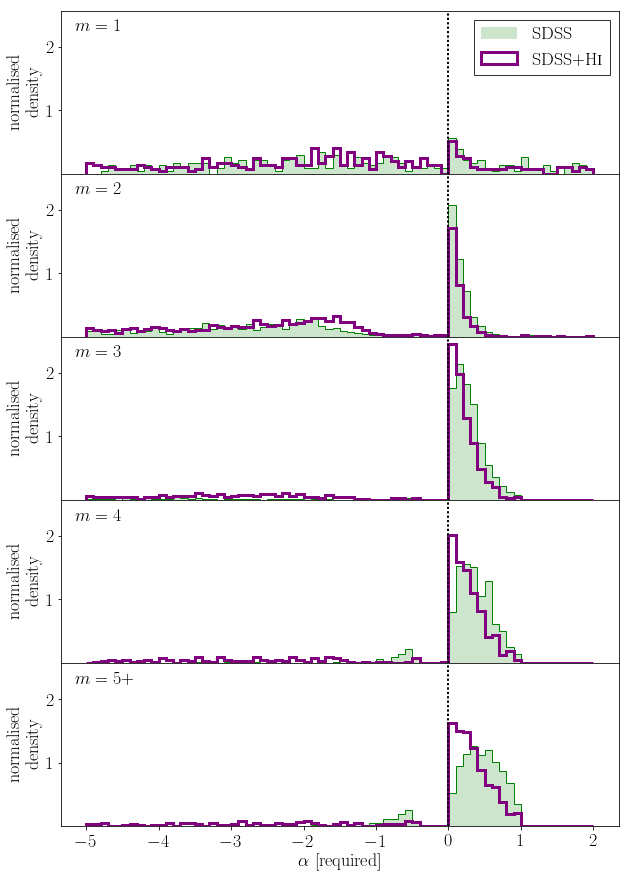

In [9]:
# what alpha do we need vs. spiral arm number

m_values = morph_data['m']

fig, axarr = plt.subplots(5,1,figsize=(10,15),sharex=True,sharey=True)
colors = ('orange','r','m','g','b')
mlabels = ('1','2','3','4','5+')
bins = np.linspace(-5,2,71)

for m in range(5):
    ax = axarr[m]
    plt.sca(ax)
    
    in_m = m_values[in_sdss] == m+1
    in_m_hi = m_values[in_sdss_hi] == m+1
    
    alpha_m = alphas[in_sdss][in_m]
    alpha_hi_m = alphas_hi[in_sdss_hi][in_m_hi]
    
    _ = ax.hist(alpha_hi_m,bins,normed=True,
                color='g',alpha=0.2,histtype='stepfilled',label='SDSS')
    _ = ax.hist(alpha_hi_m,bins,normed=True,
                color='g',lw=1,histtype='step',label='_nolegend_')
    _ = ax.hist(alpha_m,bins,normed=True,
                color='purple',histtype='step',lw=3,
                label=r'SDSS+H\textsc{i}')
    _ = ax.set_ylabel('normalised \n density')
    _ = ax.text(0.025,0.95,'$m={}$'.format(mlabels[m]),
                transform=ax.transAxes,ha='left',va='top')
    _ = plt.axvline(0,color='k',lw=2,linestyle='dotted')
    
    print('m={}: {}/{} OK'.format(mlabels[m],(alpha_m>0).sum(),
                                  len(alpha_m)))
    print('m={}: {}/{} OK [HI]'.format(mlabels[m],(alpha_hi_m>0).sum(),
                                       len(alpha_hi_m)))
    print('---')

_ = axarr[0].legend(loc='upper right',fancybox=False,edgecolor='k')
axarr[-1].set_xlabel(r'$\alpha$ [required]')

#fig.tight_layout()
fig.subplots_adjust(hspace=0)

In [10]:
# Now: how does alpha correlate with M/M_DMO [0.01R200]

def mass_enclosed_hernquist(r,M200,a_h,r200):
    return M200 * (r**2 / (r+a_h)**2)

def mass_enclosed_burkert(r,M200,a_h,rho0,r200):
    
    a = 2 * math.pi * rho0 * a_h**3
    b = (np.log((r+a_h)/a_h)
       + 0.5 * np.log((r**2 + a_h**2)/a_h**2)
       - np.arctan(r/a_h))
    return a * b

def alpha_mass_enclosed(alphas,M_burkert,M_hernquist):
    low_alpha = alphas < 0
    mid_alpha = (0 <= alphas) & (alphas <= 1)
    high_alpha = alphas > 1
    mass_enclosed = np.zeros(len(alphas))
    mass_enclosed[low_alpha] = (1+alphas[low_alpha])*M_burkert[low_alpha]
    mass_enclosed[mid_alpha] = ((1-alphas[mid_alpha])*M_burkert[mid_alpha] 
                              + alphas[mid_alpha]*M_hernquist[mid_alpha])
    mass_enclosed[high_alpha] = alphas[high_alpha]*M_hernquist[high_alpha]
    return mass_enclosed

def linear(x,m,c):
    return m*x + c

def get_hmf(table,alphas):
    M200_hernquist = table['modified_M_halo']
    M200_burkert = table['M_halo']
    R200 = table['R200']
    a_h = table['R_halo']
    rho0 = table['rho0_burkert']
    r = 0.01 * R200
    
    M_hernquist = mass_enclosed_hernquist(r,M200_hernquist,a_h,R200)
    M_burkert = mass_enclosed_burkert(r,M200_burkert,a_h,rho0,R200)
    mass_enclosed = alpha_mass_enclosed(alphas,M_burkert,M_hernquist)
    return mass_enclosed / M_hernquist

hmf = get_hmf(halo_data,alphas)
hmf_hi = get_hmf(halo_w_gas,alphas_hi)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


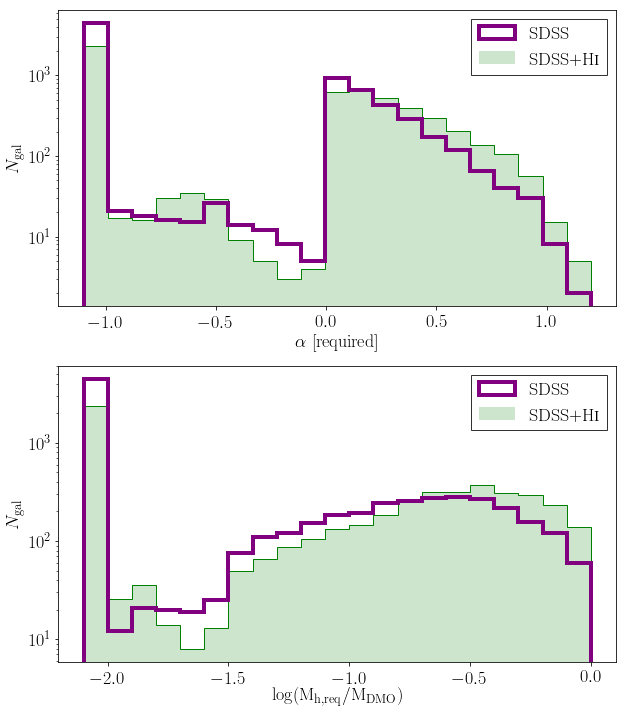

In [11]:
bins_alpha = np.linspace(-1.1,1.2,22)
alpha_ = alphas.copy()
alpha_[alpha_ < -1] = -1.1
alpha_hi_ = alphas_hi.copy()
alpha_hi_[alpha_hi_ < -1] = -1.1
#############
bins_hmf = np.linspace(-2.1,0,22)
hmf_ = np.log10(hmf.copy())
hmf_[alpha_ < -1] = -2.1
hmf_hi_ = np.log10(hmf_hi.copy())
hmf_hi_[alpha_hi_ < -1] = -2.1

def sdss_vs_sdss_hi_hist(ax,x,x_hi,bins):

    _ = ax.hist(x,bins,color='purple',lw=4,histtype='step',
                label='SDSS',zorder=2)
    _ = ax.hist(x_hi,bins,color='g',lw=1,histtype='step',
                label='_nolegend_')
    _ = ax.hist(x_hi,bins,color='g',lw=4,
                histtype='stepfilled',alpha=0.2,
                label=r'SDSS+H\textsc{i}')
    
    _ = ax.set_ylabel('$N_\mathrm{gal}$')
    _ = ax.legend(fancybox=False,edgecolor='k')
    return None

fig, axarr = plt.subplots(2,1,figsize=(10,12))

_ = sdss_vs_sdss_hi_hist(axarr[0],alpha_[in_sdss],alpha_hi_[in_sdss_hi],
                         bins_alpha)

_ = sdss_vs_sdss_hi_hist(axarr[1],hmf_[in_sdss],hmf_hi_[in_sdss_hi],
                         bins_hmf)

_ = axarr[0].set_xlabel(r'$\alpha$ [required]')
_ = axarr[1].set_xlabel('$\log(\mathrm{M_{h,req}/M_{DMO}})$')
_ = axarr[0].set_yscale('log')
_ = axarr[1].set_yscale('log')
#print((alpha_[in_sdss] == -1.1).sum(),in_sdss.sum())
#print((alpha_hi_[in_sdss_hi] == -1.1).sum(),in_sdss_hi.sum())

#fig.savefig('figures/alpha_distributions.pdf')

#### Correlate alpha w.r.t:

- Stellar mass
- disc scale length

In [12]:
M_bulge = halo_data['M_bulge']
r_bulge = halo_data['R_bulge']

r_disc = halo_data['R_disc_total']
r_disc_hi = halo_w_gas['R_disc_total']
M_disc = halo_data['M_disc_total']
M_disc_hi = halo_w_gas['M_disc_total']

r200 = halo_data['R200']

r_half = halo_data['r_half']
r_half_hi = halo_w_gas['r_half']

#### Now: need to convert the halo mass fractions

Require the following outputs:

- Halo mass (Hernquist)
- $R_{200}$
- $\rho_0$ (Burkert)

In [13]:
def m_halo_m_hernquist(r200,rho0_burkert,M_hernquist,alpha,r0):
    
    r1 = 0.01 * r200
    M_r1_hernquist = M_hernquist * (r1**2/(r1+r0)**2)
    a = 2 * math.pi * rho0_burkert * r0**3
    b = (np.log((r0+r1)/r0) 
       + 0.5 * np.log((r1**2 + r0**2)/r0**2)
       - np.arctan(r1/r0))
    
    M_r1_burkert = a * b
    M_r1_halo = alpha * M_r1_hernquist + (1-alpha) * M_r1_burkert
    return M_r1_halo / M_r1_hernquist

In [14]:
def hmf_plotter(ax,x,hmf,xlabel=None,ylabel=False,label='',
                figlabel='',letter='a',contour=True,mask=None,**kwargs):
    
    if mask is None:
        datalabel = label + ' ($N_\mathrm{{gal}}={}$)'.format(len(x))
    else:
        datalabel = label + ' ($N_\mathrm{{gal}}={}/{}$)'.format(mask.sum(),
                                                                 len(mask))
    _ = ax.scatter(x,hmf,rasterized=True,label=datalabel,**kwargs)
    _ = ax.set_ylim(-3,3)
    if xlabel is not False:
        _ = ax.set_xlabel(r'$\log(R_\mathrm{1/2}/R_{200})$')
    if ylabel is not False:
        _ = ax.set_ylabel(r'$\log(\mathrm{M_{h,req}/M_{DMO}})$ [0.01$R_{200}$]')
        
    _ = ax.text(0.025,0.975,r'({}) {}'.format(letter,figlabel),
                ha='left',va='top',transform=ax.transAxes)
    return None

def nihao_line(x):
    median_line = -0.28 - 1.52 * (1.68 + x)
    lower_line = -0.39 - 1.52 * (1.68 + x)
    upper_line = -0.17 - 1.52 * (1.68 + x)
    return median_line, lower_line, upper_line

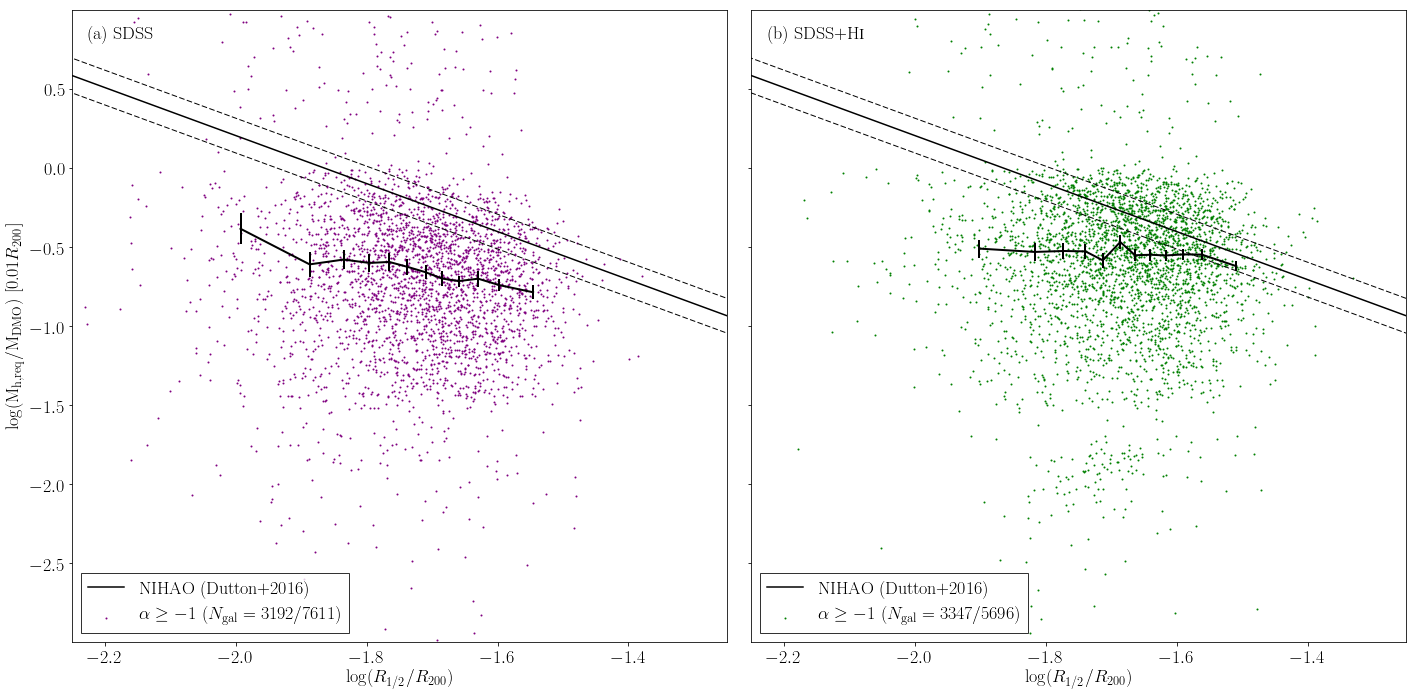

In [16]:
from scipy.stats import spearmanr
from contours import kde_contour
#from sklearn.mixture import GaussianMixture
from xy_plots import x_vs_y

fig, axarr = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
axarr = axarr.ravel()

_ = axarr[0].set_xlim(-3,-1)
_ = axarr[0].set_ylim(-3,1)

gz2_m = morph_data['m']
#alpha_ok = np.all([sample_ok,alphas >= -1],axis=0)
#alpha_ok_hi = np.all([sample_ok,alphas_hi >= -1],axis=0)
alpha_ok = np.all([in_sdss,alphas >= -1],axis=0)
alpha_ok_hi = np.all([in_sdss_hi,alphas_hi >= -1],axis=0)

contour = False

####
plt.sca(axarr[0])
x = np.log10(r_half/r200)[alpha_ok]
y = np.log10(hmf[alpha_ok])
hmf_plotter(axarr[0],x,y,True,True,color='purple',s=1,
            mask=alpha_ok[in_sdss],label=r'$\alpha \geq -1$',
            figlabel='SDSS',letter='a')

xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True,
                                                        bins=12)
xy.error_plot(axarr[0],style='errorbar',color='k',lw=2)

if contour is True:
    _ = kde_contour(x,y,fill=True,fill_properties={'colormap':'Purples'},
                    line_properties={'color':'purple'},zorder=1)


#####
plt.sca(axarr[1])
x = np.log10(r_half_hi/r200)[alpha_ok_hi]
y = np.log10(hmf_hi[alpha_ok_hi])
hmf_plotter(axarr[1],x,y,True,False,color='g',s=1,
            mask=alpha_ok_hi[in_sdss_hi],label=r'$\alpha \geq -1$',
            figlabel=r'SDSS+H\textsc{i}',letter='b')

xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True,
                                                        bins=12)
xy.error_plot(axarr[1],style='errorbar',color='k',lw=2)

if contour is True:
    _ = kde_contour(x,y,fill=True,fill_properties={'colormap':'Greens'},
                    line_properties={'color':'g'},zorder=1)

x_guide = np.linspace(-3.5,-1,100)
y_guide, y_lower, y_upper = nihao_line(x_guide)              

########    
for ax in axarr:
    _ = ax.plot(x_guide,y_guide,'k-',label='NIHAO (Dutton+2016)',zorder=2)
    _ = ax.plot(x_guide,y_lower,'k--',lw=1,zorder=2)
    _ = ax.plot(x_guide,y_upper,'k--',lw=1,zorder=2)
    _ = ax.legend(fancybox=False,edgecolor='k')

_ = axarr[0].set_xlim(-2.25,-1.25)
_ = axarr[0].set_ylim(-3,1)
fig.tight_layout()
#fig.savefig('figures/r_vs_hmf.pdf')

In [17]:
#alpha_lookup = np.concatenate([alphas_hi[alpha_ok_hi],alphas[alpha_ok]])
#hmf_lookup = np.concatenate([hmf_hi[alpha_ok_hi],hmf[alpha_ok]])
#lookup_table = Table([alpha_lookup,hmf_lookup],names=('alpha','hmf'))
'''
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def hmf_to_alpha(hmf,lookup_table=lookup_table):
    i = find_nearest(lookup_table['hmf'],alpha)
    return lookup_table['alpha'][i]
'''
    
def alpha_to_fd(alpha,Mb,Md,Mh_hernquist,Mh_burkert):
    low_alpha = alpha < 0
    mid_alpha = np.all([alpha <= 1,alpha >= 0],axis=0)
    high_alpha = alpha > 1
    
    fd = np.zeros(len(alpha))
    fd[low_alpha] = (M_d / (M_b + (1+alpha)*Mh_burkert + M_b))[low_alpha]
    fd[mid_alpha] = (M_d / (M_b + (1+alpha)*Mh_burkert + 
                            alpha*Mh_hernquist + M_b))[mid_alpha]
    fd[high_alpha] = (M_d / (M_b + (alpha)*Mh_hernquist + M_b))[high_alpha]
    
    return fd

def fd_to_m(fd,k,c):
    return k*fd + c

def nihao_adjustment(r,r200,m_hernquist,m_burkert,M_b,M_d,
                     M_h_hernquist,M_h_burkert,
                     k_h,c_h,k_b,c_b):
    x = np.log10(r/r200)
    hmf = 10**(-0.28 - 1.52 * (x+1.68))
    #alpha = hmf_to_alpha(hmf)
    alpha = hmf.copy()
    alpha[alpha<0] = 0
    high_alpha = alpha > 1
    mid_alpha = np.all([alpha >= 0,alpha <= 1],axis=0)
    low_alpha = alpha < 0
    
    m_expected = np.zeros(len(alpha))
    m_expected[mid_alpha] = ((alpha)*m_hernquist + 
                             (1-alpha)*m_burkert)[mid_alpha]
    fd = alpha_to_fd(alpha,M_b,M_d,M_h_hernquist,M_h_burkert)
    m_expected[high_alpha] = fd_to_m(fd[high_alpha],k_h,c_h)
    #m_expected[low_alpha] = fd_to_m(fd[low_alpha],k_b,c_b)
    return m_expected

def hmf_nihao(r,r200):
    x = np.log10(r/r200)
    hmf = 10**(-0.28 - 1.52 * (x+1.68))
    return hmf

hmf_expected = hmf_nihao(r_half,r200)
hmf_expected_hi = hmf_nihao(r_half_hi,r200)

m_nihao = nihao_adjustment(r_half,r200,m_hernquist,m_burkert,
                           M_b,M_d,M_h_hernquist,M_h_burkert,
                           k_h,c_h,k_b,c_b)
    
m_nihao_hi = nihao_adjustment(r_half_hi,r200,m_hernquist_hi,m_burkert_hi,
                              M_b_hi,M_d_hi,M_h_hernquist_hi,M_h_burkert_hi,
                              k_h_hi,c_h_hi,k_b_hi,c_b_hi)

In [18]:
###############
def mass_enclosed_hernquist(r,M200,a_h,r200):
    return M200 * (r**2 / (r+a_h)**2)

def mass_enclosed_burkert(r,M200,a_h,rho0,r200):
    
    a = 2 * math.pi * rho0 * a_h**3
    b = (np.log((r+a_h)/a_h)
       + 0.5 * np.log((r**2 + a_h**2)/a_h**2)
       - np.arctan(r/a_h))
    return a * b

def alpha_mass_enclosed(alphas,M_burkert,M_hernquist):
    low_alpha = alphas < 0
    mid_alpha = (0 <= alphas) & (alphas <= 1)
    high_alpha = alphas > 1
    mass_enclosed = np.zeros(len(alphas))
    mass_enclosed[low_alpha] = (1+alphas[low_alpha])*M_burkert[low_alpha]
    mass_enclosed[mid_alpha] = ((1-alphas[mid_alpha])*M_burkert[mid_alpha] 
                              + alphas[mid_alpha]*M_hernquist[mid_alpha])
    mass_enclosed[high_alpha] = (1+alphas[high_alpha])*M_hernquist[high_alpha]
    return mass_enclosed

def linear(x,m,c):
    return m*x + c

def get_hmf(table,alphas):
    M200_hernquist = table['modified_M_halo']
    M200_burkert = table['M_halo']
    R200 = table['R200']
    a_h = table['R_halo']
    rho0 = table['rho0_burkert']
    r = 0.01 * R200
    
    M_hernquist = mass_enclosed_hernquist(r,M200_hernquist,a_h,R200)
    M_burkert = mass_enclosed_burkert(r,M200_burkert,a_h,rho0,R200)

    mass_enclosed = alpha_mass_enclosed(alphas,M_burkert,M_hernquist)
    return mass_enclosed / M_hernquist


In [19]:
from xy_plots import x_vs_y

def m_avg_vs_m(ax,morph_data,mask,hi_mask,m_predicted,m_predicted_hi):

    m = morph_data['m']
    m_avg = morph_data['m_avg']

    x = m_avg[mask]
    y = m_predicted[mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label='SDSS ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(len(x),rs)

    xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True)
    _ = xy.line_plot(ax,color='purple',lw=4,label=label)
    _ = xy.error_plot(ax,style='lined',color='purple',linestyle='dashed')

    #######################
    x = m_avg[hi_mask]
    y = m_predicted_hi[hi_mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label=r'SDSS+H\textsc{{i}} ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(
          len(x),rs)

    xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True)
    _ = xy.line_plot(ax,color='g',lw=2,label=label)
    _ = xy.error_plot(ax,color='g',alpha=0.2)

    ###############
    _ = ax.plot([-10,10],[-10,10],color='k',lw=2)
    for offset in (-2,2,4,6,8):
        _ = ax.plot([-10,10],[-10+offset,10+offset],
                    color='k',lw=1,linestyle='dashed')

    _ = ax.set_xlim(1.5,5.5)
    _ = ax.set_ylim(2.5,6.5)
    _ = ax.legend(edgecolor='k',fancybox=False)
    
    return None

def m_vs_m(ax,morph_data,mask,hi_mask,m_predicted,m_predicted_hi):

    m = morph_data['m']
    m_avg = morph_data['m_avg']

    x = m[mask]
    y = m_predicted[mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label='SDSS ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(len(x),rs)

    xy = x_vs_y(x,y).discrete_vs_continuous_binned_median()
    _ = xy.line_plot(ax,color='purple',lw=4,label=label)
    _ = xy.error_plot(ax,style='lined',color='purple',linestyle='dashed')

    #######################
    x = m[hi_mask]
    y = m_predicted_hi[hi_mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label=r'SDSS+H\textsc{{i}} ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(
          len(x),rs)

    xy = x_vs_y(x,y).discrete_vs_continuous_binned_median()
    _ = xy.line_plot(ax,color='g',lw=2,label=label)
    _ = xy.error_plot(ax,color='g',alpha=0.2)

    ###############
    _ = ax.plot([-10,10],[-10,10],color='k',lw=2)
    for offset in (-2,2,4,6,8):
        _ = ax.plot([-10,10],[-10+offset,10+offset],
                    color='k',lw=1,linestyle='dashed')

    _ = ax.set_xlim(1.5,5.5)
    _ = ax.set_ylim(2.5,6.5)
    _ = ax.legend(edgecolor='k',fancybox=False)
    
    return None

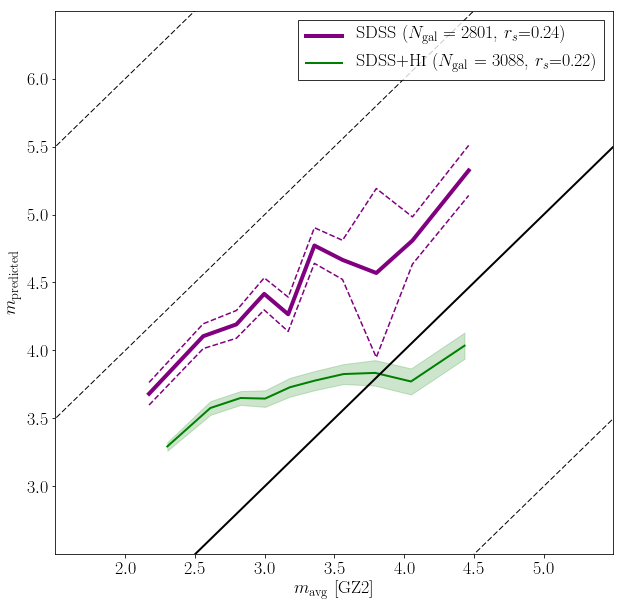

In [20]:
### Make the plots above for bins of alpha:

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
m = morph_data['m']

mask = np.all([alphas >= -1,#alphas <= 10,
               in_sdss,m>=2,m_nihao>=0],axis=0)
hi_mask = np.all([alphas_hi >= -1,#alphas_hi <= 10,
                  in_sdss_hi,m>=2,m_nihao_hi>=0],axis=0)

_ = m_avg_vs_m(ax,morph_data,mask,hi_mask,m_nihao,m_nihao_hi)

_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#fig.savefig('figures/m_vs_m_nihao.pdf')

In [21]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [22]:
fd_nihao = M_d / (M_b + M_d + hmf*M_h_hernquist)
M_total = np.log10(M_b + M_d + hmf*M_h_hernquist)
M_disc = np.log10(M_b)
u_r = gz2_data['PETROMAG_MU'] - gz2_data['PETROMAG_MR']

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


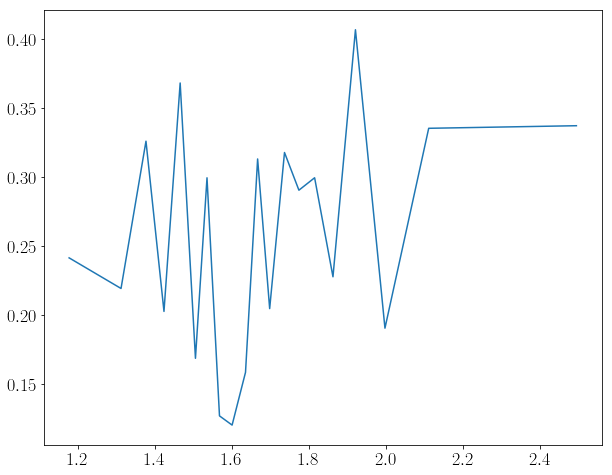

In [23]:
from bin_statistics import assign_bins
from scipy.stats import spearmanr

#mask = np.all([alphas >= 0,alphas <= 1,
               #in_sdss,m>=2,m_nihao>=0],axis=0)

x = morph_data['m_avg'][mask]
y = m_nihao[mask]
z = u_r[mask]

def moving_rs(x,y,z,N_bins=20):

    order = np.argsort(z)
    x, y, z = x[order], y[order], z[order]
    zbins = assign_bins(z,equal_N=True,N_bins=N_bins)
    
    zs = []
    rs = []
    p = []
    
    for zbin in np.unique(zbins):
        in_bin = zbins == zbin
        xbin = x[in_bin]
        ybin = y[in_bin]
        zbin = z[in_bin]
        zs.append(np.mean(zbin))
        rs.append(spearmanr(xbin,ybin)[0])
        p.append(spearmanr(xbin,ybin)[1])
    
    return zs, rs, p

z_, rs, p = moving_rs(x,y,z,20)

plt.plot(z_,rs)

(array([ 134.,  312.,  978.,  566.,  454.,  344.,  292.,  253.,  211.,
         155.,  134.,   94.,   59.,   49.,   14.,   11.,    2.,    0.,    0.]),
 array([ 1.5       ,  1.71052632,  1.92105263,  2.13157895,  2.34210526,
         2.55263158,  2.76315789,  2.97368421,  3.18421053,  3.39473684,
         3.60526316,  3.81578947,  4.02631579,  4.23684211,  4.44736842,
         4.65789474,  4.86842105,  5.07894737,  5.28947368,  5.5       ]),
 <a list of 1 Patch objects>)

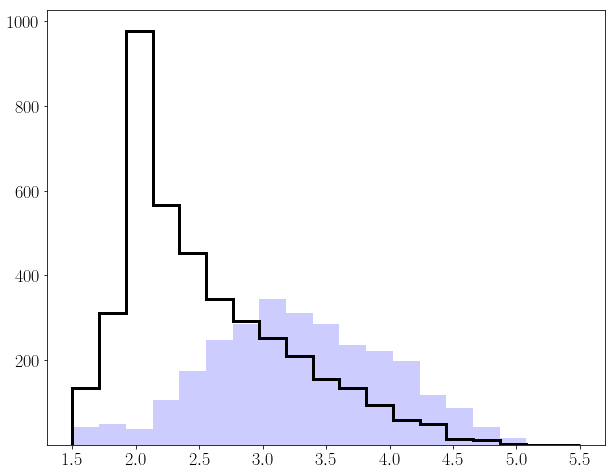

In [24]:
modal = np.all([alphas >= -1,
                in_sdss,m>=2,m_nihao>=0],axis=0)

non_modal = np.all([alphas <= -1,
                    in_sdss,m>=2,m_nihao>=0],axis=0)

bins = np.linspace(1.5,5.5,20)

plt.hist(morph_data['m_avg'][modal],bins,color='b',alpha=0.2)
plt.hist(morph_data['m_avg'][non_modal],bins,color='k',histtype='step',lw=3)

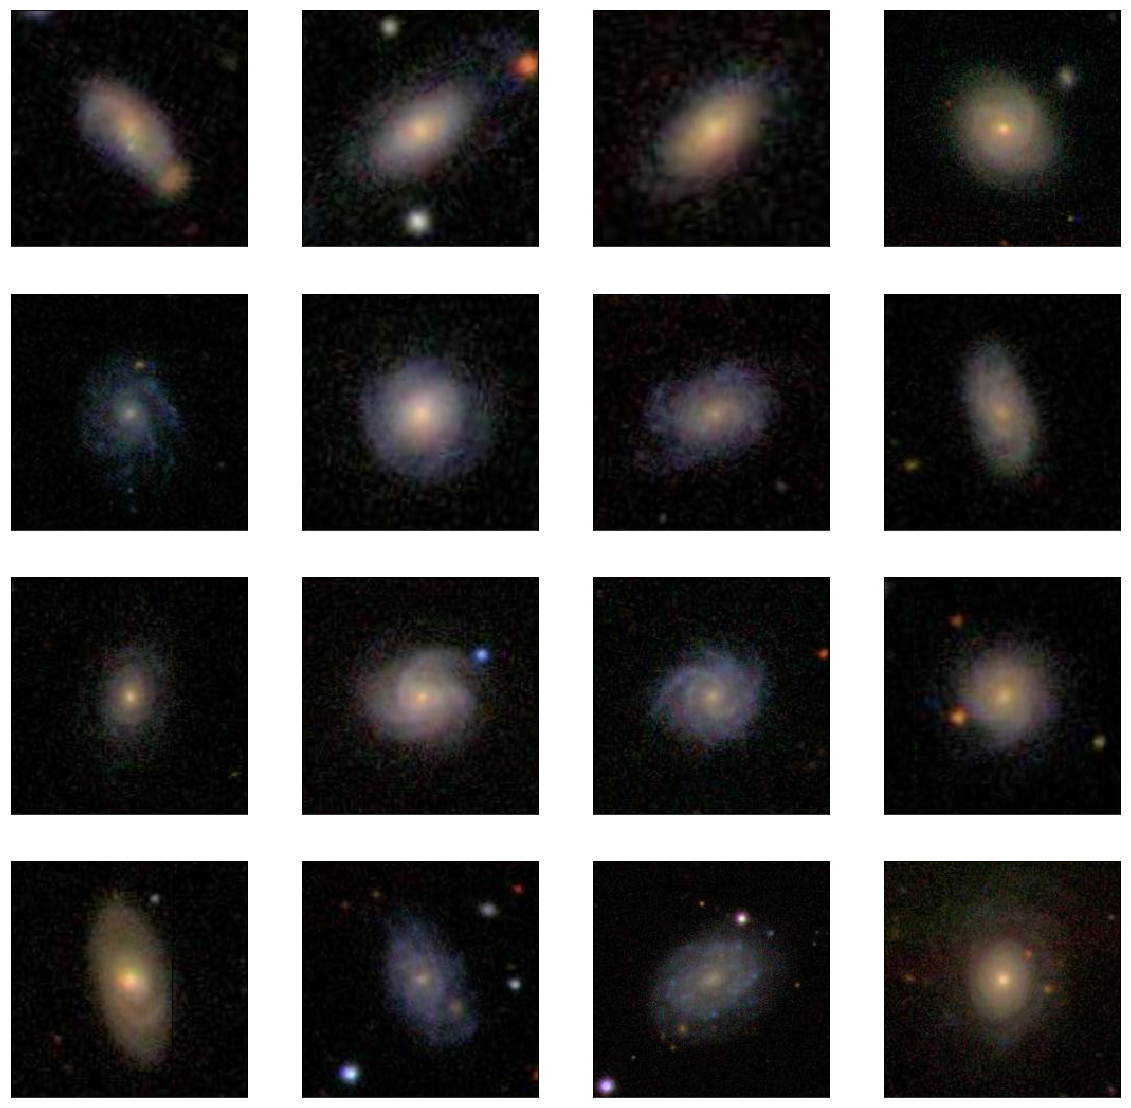

In [25]:
from display_image import display_image

np.random.seed(0)

fig, axarr = plt.subplots(4,4,figsize=(20,20))

low_z = gz2_data['REDSHIFT_1'] <= 0.085

for m, ax in enumerate(axarr):
    m_ok = morph_data['m'] == m+2
    non_modal_m = np.all([non_modal,m_ok,low_z],axis=0)
    modal_m = np.all([modal,m_ok,low_z],axis=0)
    non_modal_urls = np.random.choice(gz2_data['jpeg_url'][non_modal_m],2)
    modal_urls = np.random.choice(gz2_data['jpeg_url'][modal_m],2)
    
    plt.sca(ax[0])
    display_image(non_modal_urls[0])
    plt.sca(ax[1])
    display_image(non_modal_urls[1])
    plt.sca(ax[2])
    display_image(modal_urls[0])
    plt.sca(ax[3])
    display_image(modal_urls[1])
    

#### How does the NIHAO modification affect the correlation?

- Try this for various offsets: 

#### Now for the f_d vs. m relation for bins of alpha:

In [ ]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

def cubic(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

def n4(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

x_guide = np.linspace(0,1,1000)

fig, axarr = plt.subplots(1,2,figsize=(10,5))

p_k, _ = curve_fit(quadratic,test_alphas,ks,p0=(1,1,1))
_ = axarr[0].plot(test_alphas,ks,color='k',lw=1)
_ = axarr[0].plot(x_guide,quadratic(x_guide,*p_k),
                  color='r',lw=2,linestyle='dashed')

p_c, _ = curve_fit(n4,test_alphas,cs)
_ = axarr[1].plot(test_alphas,cs,color='k',lw=1)
_ = axarr[1].plot(x_guide,n4(x_guide,*p_c),
                  color='b',lw=2,linestyle='dashed')

_ = axarr[0].set_xlabel(r'$\alpha$')
_ = axarr[0].set_ylabel('$k$')
_ = axarr[1].set_xlabel(r'$\alpha$')
_ = axarr[1].set_ylabel('$c$')

_ = fig.tight_layout()

In [ ]:
def correct_fd(halo_table,morph_table,alphas,k_func,c_func,p_k,p_c):
    
    def fd_function(x,k,c):
        return k / x + c
    
    def inverse_fd_function(y,k,c):
        return k /(y-c)
    
    k = k_func(alphas,*p_k)
    c = c_func(alphas,*p_c)
    
    disc_mass_22 = halo_table['M_disc_total_2.2']
    bulge_mass_22 = halo_table['M_bulge_2.2']
    halo_mass_22_hernquist = halo_table['M_halo_2.2_hernquist']
    halo_mass_22_burkert = halo_table['M_halo_2.2_burkert']
    m_observed = morph_table['m_avg']
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + ((1-alpha) * halo_mass_22_burkert))
    
    fd_observed = (disc_mass_22 
                  / (disc_mass_22 + bulge_mass_22 + halo_mass_22))
    
    fd_required = inverse_fd_function(m_observed,k,c)
    
    return fd_observed, fd_required


def correct_m(halo_table,mass_correction,alphas,k_func,c_func,p_k,p_c):
    
    def fd_function(x,k,c):
        return k / x + c
    
    def inverse_fd_function(y,k,c):
        return k /(y-c)
    
    k = k_func(alphas,*p_k)
    c = c_func(alphas,*p_c)
    
    disc_mass_22 = halo_table['M_disc_total_2.2'] + mass_correction
    bulge_mass_22 = halo_table['M_bulge_2.2'] - mass_correction
    halo_mass_22_hernquist = halo_table['M_halo_2.2_hernquist']
    halo_mass_22_burkert = halo_table['M_halo_2.2_burkert']
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + ((1-alpha) * halo_mass_22_burkert))
    
    fd = (disc_mass_22 
        / (disc_mass_22 + bulge_mass_22 + halo_mass_22))
    
    m_predicted = fd_function(fd,k,c)
    return m_predicted
    

In [ ]:
mask = np.all([sample_ok,mask0],axis=0)

fd_observed, fd_required = correct_fd(halo_data[mask],morph_data[mask],
                                      alpha_nihao[mask],
                                      quadratic,n4,p_k,p_c)

mb_correction = ((fd_required-fd_observed) 
                * halo_data[mask]['M_disc_total_2.2'])

mb_22_observed = halo_data['M_bulge_2.2'][mask]
mb_22_required = mb_22_observed - mb_correction

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ok_mb = np.all([mb_22_required > 10**7,mb_22_required <= 10**13,
                mb_22_observed > 10**7,mb_22_observed <= 10**13],axis=0)

print('{}/{} have reasonable bulges'.format(ok_mb.sum(),mask.sum()))

x = np.log10(mb_22_observed[ok_mb])
y = np.log10(mb_22_required[ok_mb])
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True,bins=20)
xy.error_plot(ax,style='errorbar',color='k',lw=2)

_ = ax.scatter(x,y,s=1,color='r')
_ = ax.set_xlabel('$\log(\mathrm{M_B/M_\odot})$ [Mendel+14]')
_ = ax.set_ylabel('$\log(\mathrm{M_B/M_\odot})$ [required]')

_ = ax.set_xlim(7,12)
_ = ax.set_ylim(7,12)
_ = ax.plot([7,12],[7,12],color='k',lw=1,linestyle='dotted')

In [ ]:
bins = np.linspace(-2,3,21)
required_fraction = mb_22_required/mb_22_observed
plt.hist(required_fraction,bins,color='r',histtype='stepfilled',
         alpha=0.3)

_ = plt.xlabel('$\mathrm{M_B}$ (required) / $\mathrm{M_B}$ (observed)')
_ = plt.ylabel('$N_\mathrm{gal}$')

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.sca(ax)

x = np.log10(mb_22_observed)
y = required_fraction
xy_ok = np.all([y >= -100, y <= 100, np.isfinite(x)],axis=0)

xy = x_vs_y(x[xy_ok],y[xy_ok]).continuous_vs_continuous_binned_median(
    equal_N=True,bins=12)
xy.scatter(ax,color='r',s=1,label=label)
rs = xy.spearmanr(None,plot=False)[0]
label = r'SDSS $\alpha>1$ ($N_\mathrm{{gal}}={}$, {})'.format(len(x),rs)
xy.error_plot(ax,color='k',lw=2,style='errorbar',marker='o',capsize=2)

_ = ax.legend(fancybox=False,edgecolor='k')

_ = plt.axhline(0,linestyle='dotted',color='k')
_ = plt.axhline(1,linestyle='dotted',color='k')

p_corr, pcov = curve_fit(linear,x[xy_ok],y[xy_ok])
x_guide = np.linspace(6,12,100)
y_guide = linear(x_guide,*p_corr)

_ = ax.set_xlim(7.5,11.5)
_ = ax.set_ylim(-1,2)
_ = ax.set_xlabel('$\log(\mathrm{M_B/M_\odot})$')
_ = ax.set_ylabel('$\mathrm{M_B}$ (required) / $\mathrm{M_B}$ (observed)')

bulge_correction_x = xy.x_table['mean']
bulge_correction_y = xy.y_table['mean']

#### New task: fit the S4G...

In [ ]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')
s4g_structure = Table.read('s4g_fits/bulge_disc_matched.fits')

in_s4g = s4g['unbarred_sample']

In [ ]:
s4g_R_ratio = np.log10(1.68*s4g['R_disc_total']/s4g['R200'])
s4g_alpha_nihao = 10**(nihao_line(s4g_R_ratio)[0])

In [ ]:
m_hernquist_s4g = s4g['m_hernquist_2R_d']
m_burkert_s4g = s4g['m_burkert_2R_d']

s4g_m_mod = m_predicted(m_burkert_s4g,m_hernquist_s4g,s4g_alpha_nihao)

In [ ]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

arm_class = s4g_morph['AC'][in_s4g]
ac_number = np.zeros(len(arm_class))
ac_number[arm_class == b'G'] = 1
ac_number[arm_class == b'M'] = 2
ac_number[arm_class == b'F'] = 3

x = ac_number.copy()
y_h = s4g['m_hernquist_2R_d'][in_s4g]
y_b = s4g['m_burkert_2R_d'][in_s4g]
y_nihao = s4g_m_mod[in_s4g]

xy_h = x_vs_y(x,y_h).discrete_vs_continuous_binned_median()
xy_b = x_vs_y(x,y_b).discrete_vs_continuous_binned_median()
xy_nihao = x_vs_y(x,y_nihao).discrete_vs_continuous_binned_median()

_ = xy_h.error_plot(ax,lw=4,style='errorbar',
                    color='orangered',label=r'S$^4$G (Hernquist)',
                    linestyle='dashed',capsize=4,capthick=2,marker='o')
_ = xy_b.error_plot(ax,lw=2,style='errorbar',
                    color='darkblue',label=r'S$^4$G (Burkert)',
                    capsize=4,capthick=2,marker='s')

_ = xy_nihao.error_plot(ax,lw=1,style='errorbar',
                        color='k',label=r'S$^4$G (NIHAO)',
                        capsize=4,capthick=1,marker='^')

_ = ax.set_xlabel('arm class')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(['G','M','F'])
_ = ax.legend(fontsize=15,fancybox=False,edgecolor='k')

#fig.savefig('figures/m_vs_m_s4g.pdf')
print(xy_h.y_table)

#### Final task: test a set of variables w.r.t |alpha-alpha (predicted)|

In [ ]:
#gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [ ]:
'''
x = np.array(bulge_correction_x)#[5:]
y = np.array(bulge_correction_y)#[5:]
plt.scatter(x,y,color='k')
    
func = cubic

p, _ = curve_fit(func,x,y)
x_g = np.linspace(8.5,10.5,100)
y_g = func(x_g,*p)
plt.plot(x_g,y_g,color='r')
'''

In [ ]:
mask = np.all([sample_ok,alphas > -1],axis=0)

delta_hmf = np.abs(np.log10(hmf) - np.log10(hmf_expected))[mask]
density = gz2_data['IVAN_DENSITY']
p_loose = gz2_data['t10_arms_winding_a30_loose_debiased_rh']
p2 = gz2_data['t11_arms_number_a32_2_debiased_rh']
f2 = morph_data['m'] == 2
m_bulge = np.log10(halo_data['M_bulge'])
m_bulge[np.isfinite(m_bulge) == False] = 7

columns = ['t10_arms_winding_a30_loose_debiased_rh',
           't10_arms_winding_a29_medium_debiased_rh',
           't10_arms_winding_a28_tight_debiased_rh']

In [ ]:
from contours3 import xyz_contour

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
plt.sca(ax)

x = morph_data['m_avg'][mask]
y = m_predicted_nihao[mask]
z = p_loose[mask]

_ = xyz_contour(x,y,z,y_range=(0,10),fill_properties={'colormap':'viridis'})
_ = plt.colorbar()
_ = plt.xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = plt.ylabel('$m_\mathrm{predicted}$')

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
plt.sca(ax)

x = morph_data['m_avg'][mask]
y = m_predicted_nihao[mask]
z = density[mask]

_ = xyz_contour(x,y,z,y_range=(0,10),fill_properties={'colormap':'viridis'})
_ = plt.colorbar()